In [117]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [118]:
X_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Bayes_classifier\X.csv'
                          ,header=None
                          ,names=[i for i in range(1,55)]
                        )
Y_raw = pd.read_csv(r'S:\Columbia MS DS\Courses\Semester_02\03 - COMS_4721 - ML for DS\HW 2\hw2-data\Bayes_classifier\Y.csv'
                          ,header=None
                          ,names=['spam']
                        )

In [245]:
X_raw.head(3)
#Y_raw.head(3)

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
0,0,6,6,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,8,0,0
1,2,3,5,0,1,3,2,1,0,9,...,0,0,0,0,0,1,0,4,2,0
2,1,0,7,0,12,2,2,1,6,3,...,1,1,0,0,0,1,0,3,2,0


In [160]:
#split data
permuted_indices = np.random.permutation(len(X_raw))
#print(permuted_indices)

X_folds = []
Y_folds = []
for i in range(10):
    X_folds.append(X_raw.iloc[permuted_indices[i::10]])
    Y_folds.append(Y_raw.iloc[permuted_indices[i::10]])
#dfs[0].shape
#Y_folds

## Logistic Regression

In [161]:
#remake folds using same index shuffle from naive bayes
heldout = 1
X_train = pd.concat([X_folds[i] for i in range(0,10) if i != heldout])
X_train['intercept'] = pd.Series(np.ones(X_train.shape[0]), index=X_train.index)
y_train = pd.concat([Y_folds[i] for i in range(0,10) if i != heldout])
y_train.loc[(y_train.spam==0),'spam'] = -1
X_test = pd.concat([X_folds[heldout]])
X_test['intercept'] = pd.Series(np.ones(X_test.shape[0]), index=X_test.index)
y_test = pd.concat([Y_folds[heldout]])
y_test.loc[(y_test.spam==0),'spam'] = -1

In [171]:
%%time

loss_CV = []  #will have array with each value an arry of losses per iteration

for h in range(0,10):
    heldout = h
    X_train = pd.concat([X_folds[i] for i in range(0,10) if i != heldout])
    X_train['intercept'] = pd.Series(np.ones(X_train.shape[0]), index=X_train.index)
    y_train = pd.concat([Y_folds[i] for i in range(0,10) if i != heldout])
    y_train.loc[(y_train.spam==0),'spam'] = -1
    X_test = pd.concat([X_folds[heldout]])
    X_test['intercept'] = pd.Series(np.ones(X_test.shape[0]), index=X_test.index)
    y_test = pd.concat([Y_folds[heldout]])
    y_test.loc[(y_test.spam==0),'spam'] = -1
    
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    stepsize = 0.01/4600
    weights = pd.Series([0.0] * 55) #includes intercept *at end* position
    weight_array = []
    weight_array.append(weights)
    loss_array = []
    n = X_train.shape[0]   #n = 20  #for testing
    t = 1000 #iterations

    for t in range(1,t+1):
        grad = pd.Series([0.0] * 55)
        loss = 0
        for i in range(0,n):
            #yi = y_train.iloc[i].item()
            #xi = X_train.iloc[i]
            yi = y_train[i].item()
            xi = X_train[i]
            expVal = np.dot(yi*xi,weights).item()
            sig = np.exp(expVal)/(1+np.exp(expVal))
            loss = loss + np.log(sig)
            grad = grad + np.dot((1-sig)*yi,xi) 
        #print('asdf')
        weights = weights + stepsize * grad     
        weight_array.append(weights)
        loss_array.append(loss)
    
    loss_CV.append(loss_array)
    #40 mins for 1000 iterations, 1 batch. 1.2 seconds per n loop ()

CPU times: total: 53min
Wall time: 1h 12s


In [172]:
loss_array[1000-1] #-926.7962

-928.897918510298

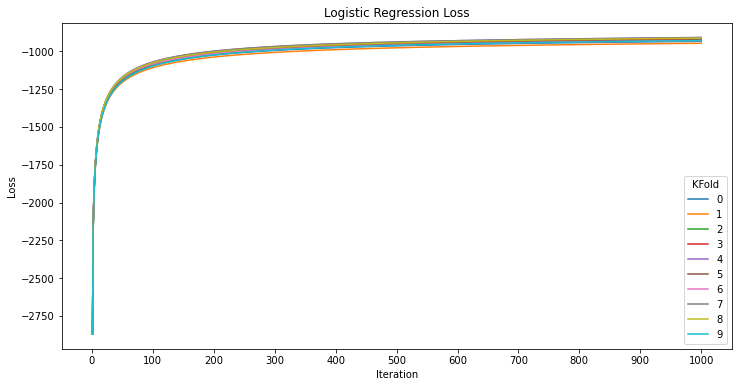

In [176]:
#plotting loss for each CV
logr_loss_df = pd.DataFrame(loss_CV, columns=[i for i in range(1,len(loss_CV[0])+1)])
ax = logr_loss_df.T.plot(figsize=(12, 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration')
plt.xticks(np.arange(0, 1001, 100))    #number of iterations
plt.legend(title='KFold')
ax.set_title('Logistic Regression Loss')
plt.show()

### Newtons

In [177]:
%%time

loss_CV_newton = [] 
weight_CV_newton = []

for h in range(0,10):
    heldout = h
    X_train = pd.concat([X_folds[i] for i in range(0,10) if i != heldout])
    X_train['intercept'] = pd.Series(np.ones(X_train.shape[0]), index=X_train.index)
    y_train = pd.concat([Y_folds[i] for i in range(0,10) if i != heldout])
    y_train.loc[(y_train.spam==0),'spam'] = -1
    X_test = pd.concat([X_folds[heldout]])
    X_test['intercept'] = pd.Series(np.ones(X_test.shape[0]), index=X_test.index)
    y_test = pd.concat([Y_folds[heldout]])
    y_test.loc[(y_test.spam==0),'spam'] = -1

    stepsize = 1 #0.01/4600
    weights = pd.Series([0.0] * 55) #includes intercept *at end* position
    weight_array_newton = []
    weight_array_newton.append(weights)
    loss_array_newton = []
    n = X_train.shape[0]   #n = 20  #for testing
    t = 100 #iterations

    for t in range(1,t+1):
        grad = pd.Series([0.0] * 55)
        hessian = np.zeros((len(weights), len(weights)))
        loss = 0
        for i in range(0, X_train.shape[0]):
            yi = y_train.iloc[i].item()
            xi = X_train.iloc[i]
            expVal = np.dot(yi*xi,weights)
            sig = np.exp(expVal)/(1+np.exp(expVal))
            grad = grad + np.dot((1-sig)*yi,xi)
            
            loss = loss + np.log(sig)
            
            #expVal2 = np.dot(xi, weights)
            #sig2 =  np.exp(expVal2)/(1+np.exp(expVal2))
            #hessian += sig2 * (1 - sig2) * np.outer(xi, xi)
            expVal2 = expVal
            sig2 = np.exp(expVal2)/(1+np.exp(expVal2))
            hessian += sig2 * (1 - sig2) * np.outer(xi, xi.T)
            
            
        sq_inv = np.linalg.inv(-hessian) 
        
        weights = weights - (stepsize * np.dot(sq_inv, grad)) #step size = 1?
        
        weight_array_newton.append(weights)
        loss_array_newton.append(loss)
        
    loss_CV_newton.append(loss_array_newton)
    weight_CV_newton.append(weights)

<timed exec>:31: RuntimeWarning: overflow encountered in exp
<timed exec>:31: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:40: RuntimeWarning: overflow encountered in exp
<timed exec>:40: RuntimeWarning: invalid value encountered in double_scalars


CPU times: total: 25min 40s
Wall time: 31min 44s


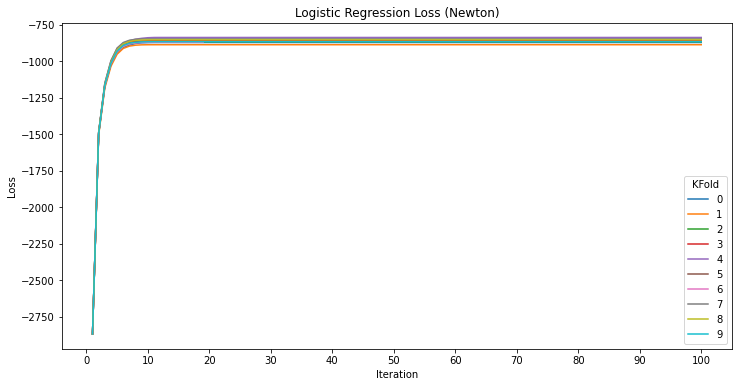

In [178]:
#graphing
logr_loss_df = pd.DataFrame(loss_CV_newton, columns=[i for i in range(1,len(loss_CV_newton[0])+1)])
ax = logr_loss_df.T.plot(figsize=(12, 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration')
plt.xticks(np.arange(0, 101, 10))    #number of iterations
plt.legend(title='KFold')
ax.set_title('Logistic Regression Loss (Newton)')
plt.show()

In [115]:
#predictions
def predict_newton(X_test_df, weights):
    expVal = np.dot(X_test_df, weights)
    output_prob = np.exp(expVal)/(1+np.exp(expVal))
    if output_prob > 0.5:
        return 1 
    else:
        return -1

In [108]:
#weight_CV_newton[1]
#newton_avg_w = pd.DataFrame(weight_CV_newton).mean()
#predict_newton(X_test.iloc[100], newton_avg_w)

0

In [179]:
#newton_avg_w = pd.DataFrame(weight_CV_newton).mean()

T_That = 0
T_Fhat = 0
F_That = 0
F_Fhat = 0

for h in range(0,10):
    heldout = h
    X_test = pd.concat([X_folds[heldout]])
    X_test['intercept'] = pd.Series(np.ones(X_test.shape[0]), index=X_test.index)
    y_test = pd.concat([Y_folds[heldout]])
    y_test.loc[(y_test.spam==0),'spam'] = -1
    
    newton_weight = weight_CV_newton[h]
    for x in range(0,X_test.shape[0]):
            y_hat = predict_newton(X_test.iloc[x], newton_weight)
            y_true = y_test.iloc[x].item()
            #print(f'True Y:{y_true} ----  Predict Y:{y_hat}')
            if(y_true == y_hat and y_true == 1):
                T_That += 1
            elif(y_true == y_hat and y_true == -1):
                F_Fhat += 1
            elif(y_true != y_hat and y_true == 1):
                T_Fhat += 1
            elif(y_true != y_hat and y_true == -1):
                F_That += 1

#print aggregate summary
print('      True                          False         ')
print(f' True Positive: {T_That} --- False Positive: {F_That}') #predicted true
print(f'False Negative: {T_Fhat} ---  True Negative: {F_Fhat}') #predicted false
print(f'Prediction Accuracy: {(T_That+F_Fhat)/(T_That+F_That+T_Fhat+F_Fhat):0.3}')
    

      True                          False         
 True Positive: 1428 --- False Positive: 124
False Negative: 385 ---  True Negative: 2663
Prediction Accuracy: 0.889
